# Graphing catalog numbers vs rank

Are collection codes typically sequential? Let's graph only numeric codes (can do work to conver alpha-numeric codes to based 10 numeric) vs their rank. If codes are sequential we should have a straight line with slope = 1.

In [44]:
import pyspark.sql.functions as sql
import pyspark.sql.types as types

In [6]:
idb_df_version = "20170130"
idb_df = sqlContext.read.parquet("/guoda/data/idigbio-{0}.parquet".format(idb_df_version))
idb_df.count()

75569035

To test our code, find one collection that seems to have numeric ids. Go to the search API and find the most common catalog number:

[http://search.idigbio.org/v2/summary/top/records?top_fields=catalognumber&count=100](http://search.idigbio.org/v2/summary/top/records?top_fields=catalognumber&count=100)

(It is possible that some collections use "good" catalog numbers that are UUIDs or other forms of GUIDs. This work can never apply to them.)

And then look for collection codes that use something popular like "100":

[http://search.idigbio.org/v2/summary/top/records?top_fields=recordset&rq={%22catalognumber%22:%22100%22}](http://search.idigbio.org/v2/summary/top/records?top_fields=recordset&rq={%22catalognumber%22:%22100%22})

Looks like the recordset a6eee223-cf3b-4079-8bb2-b77dad8cae9d has 4 records with this number and 6M records so it sounds interesting but let's start with 271a9ce9-c6d3-4b63-a722-cb0adc48863f since it has 1.8M records and will be a bit easier to work with.

In [16]:
subset = (idb_df
          .select(idb_df.catalognumber)
          .where(idb_df.recordset == "271a9ce9-c6d3-4b63-a722-cb0adc48863f")
          )
subset.cache()
subset.count()

1870300

## Is there anything that is not numeric?

In [17]:
print(subset.where(subset.catalognumber == "0").count())

0


In [45]:
def to_int(s):
    try:
        return int(s)
    except:
        # 0 is a terrible flag value but it is graphable so we can see
        # how bad things are
        return 0
    
to_int_udf = sql.udf(to_int, types.IntegerType())

In [46]:
catalognumbers = (subset
                  .withColumn("number", to_int_udf(subset.catalognumber))
                  )

In [47]:
print(catalognumbers.where(catalognumbers.number == 0).count())

500279


In [48]:
catalognumbers.where(catalognumbers.number == 0).head(10)

[Row(catalognumber='r-70049', number=0),
 Row(catalognumber='a-121712', number=0),
 Row(catalognumber='r-108613', number=0),
 Row(catalognumber='ipga-20754', number=0),
 Row(catalognumber='a-4510', number=0),
 Row(catalognumber='a-133146', number=0),
 Row(catalognumber='r-152495', number=0),
 Row(catalognumber='a-102262', number=0),
 Row(catalognumber='a-8471', number=0),
 Row(catalognumber='r-1784', number=0)]

In [49]:
catalognumbers.where("catalognumber='r-70049' OR catalognumber='70049'").head(10)

[Row(catalognumber='r-70049', number=0),
 Row(catalognumber='70049', number=70049),
 Row(catalognumber='70049', number=70049),
 Row(catalognumber='70049', number=70049),
 Row(catalognumber='70049', number=70049),
 Row(catalognumber='70049', number=70049)]

Well there certainly is and there are repeated catalog numbers too. We certainly can't assume that 'r-70049' is the same as '70049' and if we could we certainly can't guess at the catalog number practices across collections.

## Graphing

So let's just throw this on a graph.

In [50]:
catalognumbers_pd = (catalognumbers
                     .select(catalognumbers.number)
                     .sort(catalognumbers.number)
                     .toPandas()
                     )

In [51]:
catalognumbers_pd.describe()

,number
count,1.870300e+06
mean,1.360576e+05
std,1.592863e+05
min,0.000000e+00
25%,0.000000e+00
50%,8.840300e+04
75%,1.934892e+05
max,3.107998e+06


In [53]:
catalognumbers_pd[-10:]

,number
1870290,678476
1870291,678477
1870292,678478
1870293,678479
1870294,678480
1870295,678481
1870296,678482
1870297,1125825
1870298,1125828
1870299,3107998


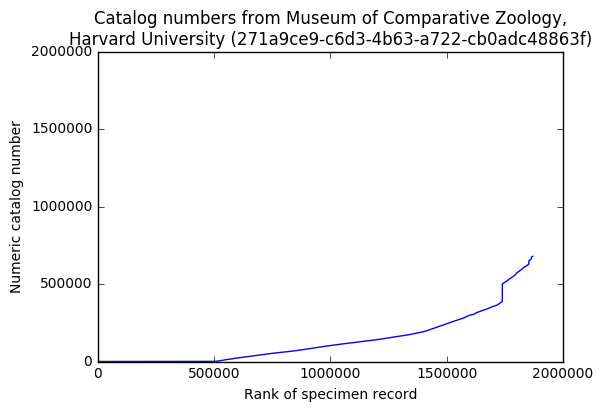

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(catalognumbers_pd.index.values[:-3],
         catalognumbers_pd[:-3]["number"])
plt.axis([0, 2000000, 0, 2000000])
plt.xlabel("Rank of specimen record")
plt.ylabel("Numeric catalog number")
plt.title("Catalog numbers from Museum of Comparative Zoology,\nHarvard University (271a9ce9-c6d3-4b63-a722-cb0adc48863f)")

Let's zoom in on some interesting parts.

[1418000, 1419000, 199000, 201000]

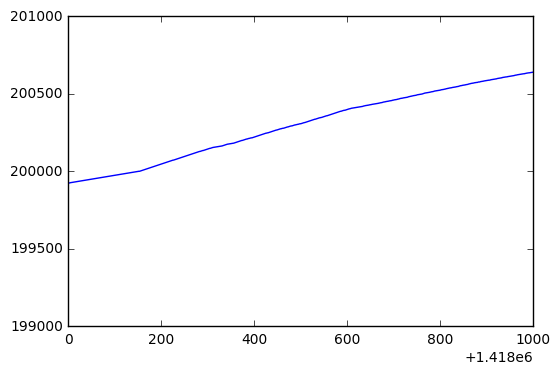

In [75]:
x_start = 1418000
x_end = 1419000
y_start = 199000
y_end = 201000

plt.plot(catalognumbers_pd.index.values[x_start:x_end],
         catalognumbers_pd[x_start:x_end]["number"])
plt.axis([x_start, x_end, y_start, y_end])

[1850000, 1875000, 600000, 700000]

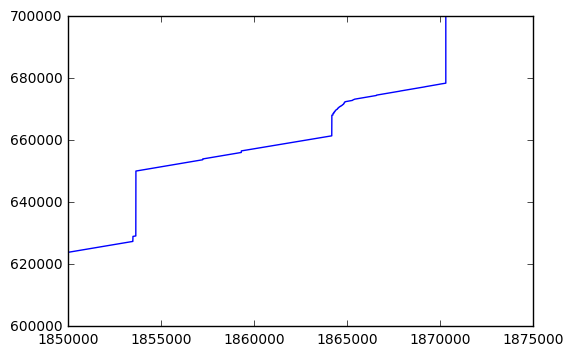

In [83]:
x_start = 1850000
x_end = 1875000
y_start = 600000
y_end = 700000

plt.plot(catalognumbers_pd.index.values[x_start:x_end],
         catalognumbers_pd[x_start:x_end]["number"])
plt.axis([x_start, x_end, y_start, y_end])

## Observations

1. Even a recordset with lots of sequential catalog numbers can have non-numeric ones that can't be interpreted or equated easily.
1. Catalog numbers can break sequence like the last 3 in the recordset which are excluded from the graph.
1. Slopes below 1 indicate that catalog numbers are being repeated.
1. Changes in slope indicate a systemic change in the repetition of catalog numbers.
1. Vertical lines are breaks in sequence.\
1. Maybe the tank problem approach only would apply to recently digitized materials like the final graph.
